# Vector Field Flow

In [1]:
import numpy as np
import scipy as sp
from scipy.optimize import minimize
import pandas as pd
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap
import ipynb.fs.defs.Functions_Equations_Equilibrium_Simulation as baseFuncs
import ipynb.fs.defs.Functions_Behavioral_Stability as stabFuncs

### Evaluate Field

In [2]:
def fieldGrids(para, bnds = ((1, 1000), (1, 1000)), mesh = 20, scale = 'log', triangle = False):
    """
    Evaluate the field at positions on a grid. To make the log-log plot work, the rule values are increased by 1 in fieldGrids and related functions.
    """
    w = para['w_max']/para['k_A']
    a_gap = int(mesh/25)
    if scale == 'log':
        x = np.geomspace(bnds[1][0], bnds[1][1], mesh)
        y = np.geomspace(bnds[0][0], bnds[0][1], mesh)
        #a_x = np.geomspace(bnds[1][0], bnds[1][1], mesh*a_gap)
        #a_y = np.geomspace(bnds[0][0], bnds[0][1], mesh*a_gap)
    else:
        x = np.linspace(bnds[1][0], bnds[1][1], mesh)
        y = np.linspace(bnds[0][0], bnds[0][1], mesh)
        #a_x = np.linspace(bnds[1][0], bnds[1][1], mesh*a_gap)
        #a_y = np.linspace(bnds[0][0], bnds[0][1], mesh*a_gap)
    Ro_grid, Ru_grid = np.meshgrid(x, y, indexing='ij')
    ARo_pos_grid, ARu_pos_grid = np.meshgrid(x, y, indexing='ij')
    dRu_grid = Ru_grid*np.nan # Derivative Ru grid
    dRo_grid = Ro_grid*np.nan
    ARu_dir_grid = ARu_pos_grid*np.nan
    ARo_dir_grid = ARo_pos_grid*np.nan
    
    for Ro_idx in range(mesh):
        for Ru_idx in range(mesh): # Make sure this matches the mesh for the dR grids
            if triangle and Ru_grid[Ro_idx, Ru_idx] + Ro_grid[Ro_idx, Ru_idx] <= w:
                deriv = baseFuncs.behavioral_eqns((Ru_grid[Ro_idx, Ru_idx], Ro_grid[Ro_idx, Ru_idx]), para)
                dRu_grid[Ro_idx, Ru_idx] = deriv[0]
                dRo_grid[Ro_idx, Ru_idx] = deriv[1]
                if Ru_idx % a_gap == 0 and Ro_idx % a_gap == 0: # Make sure that your R grid mesh is a multiple of the arrow mesh. This mod avoid looping again
                    ARu_dir_grid[Ro_idx, Ru_idx] = deriv[0]
                    ARo_dir_grid[Ro_idx, Ru_idx] = deriv[1]
                # ARu_dir_grid[int(Ro_idx), int(Ru_idx)] = deriv[0]
                # ARo_dir_grid[int(Ro_idx), int(Ru_idx)] = deriv[1] 
            elif not triangle:
                deriv = baseFuncs.behavioral_eqns((Ru_grid[Ro_idx, Ru_idx], Ro_grid[Ro_idx, Ru_idx]), para)
                dRu_grid[Ro_idx, Ru_idx] = deriv[0]
                dRo_grid[Ro_idx, Ru_idx] = deriv[1]
                ARu_dir_grid[Ro_idx, Ru_idx] = deriv[0]
                ARo_dir_grid[Ro_idx, Ru_idx] = deriv[1] 

    return Ro_grid, Ru_grid, dRo_grid, dRu_grid, ARo_pos_grid, ARu_pos_grid, ARo_dir_grid, ARu_dir_grid

In [3]:
def equilTriScatter(ax, para, x0s, bnds, fontsize, scale = 'log', triangle = False):
    # Get eql points
    eql_pnts, _ = baseFuncs.equilFuncBehavioral(para, x0s = x0s, all_results = True)
    eql_pnts = sorted(eql_pnts)
    if triangle:
        eql_pnts = [pnt for pnt in eql_pnts if pnt[0] >= bnds[0][0] and pnt[0] <= bnds[0][1] and pnt[1] >= bnds[1][0] and pnt[1] <= bnds[1][1]] # and np.sum(pnt) <= bnds[1][1]*(1-(pnt[0]+1)/bnds[0][1])]
    else:
        eql_pnts = [pnt for pnt in eql_pnts if pnt[0] >= bnds[0][0] and pnt[0] <= bnds[0][1] and pnt[1] >= bnds[1][0] and pnt[1] <= bnds[1][1]]
    
    if len(eql_pnts) != 0:
        scat_x, scat_y = zip(*eql_pnts)
        scat_x = np.asarray(scat_x)
        scat_y = np.asarray(scat_y)

        # From previous    
        cmap = colors.ListedColormap(["red", 'green'])
        col = np.asarray([stabFuncs.jacobian_eignvalues(Rs, para, only_stab = 1) for Rs in eql_pnts])
        if eql_pnts[0][0] == 0 and eql_pnts[0][1] == para['w_max']/para['k_A'] and col[0]:
            ax.scatter(scat_x[0]+3, scat_y[0]-3, zorder = 3, c = "red", marker = "o", linewidth = 3, label = "Run-Away Administrative Bloat")
        scat_x = scat_x[1:]
        scat_y = scat_y[1:]
        col = col[1:]
        ax.scatter(scat_x[col == 1], scat_y[col == 1], zorder = 2, c = "green",  marker = "^", linewidth = 3, label = "Sustainable Equilibrium")

        if triangle:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.plot([1.01*bnds[0][1], -0.01*bnds[1][1]], [-0.01*bnds[0][1], 1.01*bnds[1][1]], color = "black", linewidth = 0.75, zorder = -1)
            if scale == 'log':
                ax.set_xlim([bnds[0][0]+1, bnds[0][1]+1])
                ax.set_ylim([bnds[1][0]+1, bnds[1][1]+1])
            else:
                ax.set_xlim([bnds[0][0], bnds[0][1]])
                ax.set_ylim([bnds[1][0], bnds[1][1]])


def vectorPanel(para, ax, seed_points, x0s, fontsize, width = 0.0075, bnds = ((1, 60001), (1, 1001)), mesh = 20, 
                scale = 'log', triangle = False, stream_plot = False):
    Ro_grid, Ru_grid, dRo_grid, dRu_grid, ARo_pos_grid, ARu_pos_grid, ARo_dir_grid, ARu_dir_grid = fieldGrids(para, bnds, mesh, scale, triangle)
    ax.quiver(ARu_pos_grid, ARo_pos_grid, ARu_dir_grid, ARo_dir_grid, width = width, color = "gray")
    if stream_plot:
        ax.streamplot(Ru_grid, Ro_grid, dRu_grid, dRo_grid, color='blue', start_points = seed_points.T, 
                      linewidth=1, zorder = 1, broken_streamlines = False, density = 1.5)
    equilTriScatter(ax, para, x0s, bnds, fontsize, scale, triangle)
    if scale == 'log':
        ax.set_yscale('log')
        ax.set_xscale('log')

### Plot Field

C:\Users\grenier\MIT Dropbox\Levi Grenier\Rule dynamics\Up to date code\Modularized code\Functions_Equations_Equilibrium_Simulation.ipynb:249: RuntimeWarning: invalid value encountered in scalar power
  "    sign is a parameter that allows us to change the sign of the output. This allows us to use SciPy's Minimize function.\n",


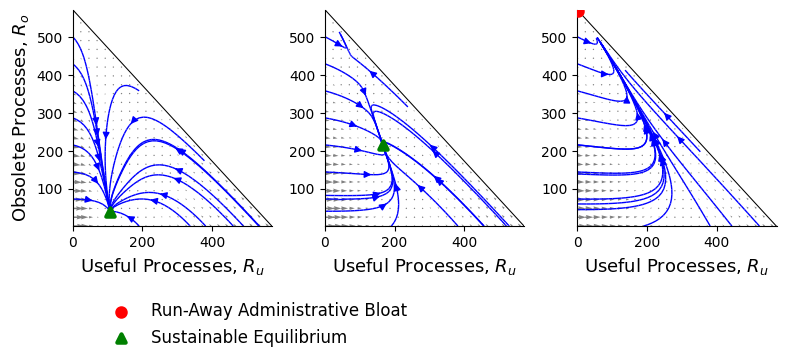

In [4]:
saveFig = False
fontsize = 13

# Set up
fig, axs = plt.subplots(1, 3, figsize=(8, 3))
axs = axs.flat

para = baseFuncs.paraReset()
para['b'] = 0
para['r_d'] = 0.1
w = para['w_max']/para['k_A']
bnds = ((0,  w + 1), (1, w + 1))
seed_mesh1 = 4
seed_mesh2 = 9
seed_points1 = [x for x in list(np.linspace(bnds[0][0], bnds[0][1], seed_mesh1)) for y in list(np.linspace(bnds[1][0], bnds[1][1], seed_mesh2))]
seed_points2 = [y for x in list(np.linspace(bnds[0][0], bnds[0][1], seed_mesh1)) for y in list(np.linspace(bnds[1][0], bnds[1][1], seed_mesh2))]
seed_points = np.array([seed_points1, seed_points2])
x0s = [[x,y] for x in list(np.geomspace(bnds[0][0]+1, bnds[0][1]+1, 20)) for y in list(np.geomspace(bnds[1][0]+1, bnds[1][1]+1, 20))]

# FIRST PANEL
para['gamma_c'] = 0.5
para['gamma_p'] = 0.15
para['r_d'] = 0.1
para['k_P'] = 20
vectorPanel(para, axs[0], seed_points, x0s, fontsize, bnds = bnds, mesh = 50, triangle = True, scale = 'lin', stream_plot = True)
axs[0].set_ylabel(r"Obsolete Processes, $R_o$", fontsize = fontsize)
axs[0].set_xlabel(r"Useful Processes, $R_u$", fontsize = fontsize)

# SECOND PANEL
para['gamma_c'] = 0.8
para['gamma_p'] = 0.15
para['r_d'] = 0.1
para['k_P'] = 40
vectorPanel(para, axs[1], seed_points, x0s, fontsize, bnds = bnds, mesh = 50, triangle = True, scale = 'lin', stream_plot = True)
axs[1].set_xlabel(r"Useful Processes, $R_u$", fontsize = fontsize)

# THIRD PANEL
para['gamma_c'] = 0.9
para['gamma_p'] = 0.15
para['r_d'] = 0.1
para['k_P'] = 40
vectorPanel(para, axs[2], seed_points, x0s, fontsize, bnds = bnds, mesh = 50, triangle = True, scale = 'lin', stream_plot = True)
axs[2].set_xlabel(r"Useful Processes, $R_u$", fontsize = fontsize)

# Create Legend
handles, labels = plt.gca().get_legend_handles_labels() # This iand the next line remove duplicate legend entries
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.12,0.02), loc = "upper left", frameon = False, fontsize = 12)

# Subplot Lettering
custom_lines = [Line2D([0], [0], color='black', linestyle = ":", lw=0.0001)] # Line that doesn't show up
custom_line_blue = [Line2D([0], [0], color='blue', linestyle = "-", lw=1)]

# Finalities
plt.tight_layout(pad = 1.2)
if saveFig:
    plt.savefig("Vector Field Grey Arrows.png", dpi = 700, bbox_inches = "tight")
else:
    plt.show()